# Šachmatų partijų analizė
Atliko: Tomas Suchockas
Duomenų šaltinis: https://www.kaggle.com/arevel/chess-games/tasks?taskId=5580
Šiame darbe analizuojamos šachmatų partijos, žaisto LiChess platformoje. 
Duomenų stulpeliai:
1. Event - šahmato partijos tipas
2. White - baltųjų figurėlių žaidėjo vartotojo vardas
3. Black - juodųjų figurėlių žaidėjo vartotojo vardas
4. Result - žaidimo rezultatas
5. WhiteElo - baltųjų figurėlių žaidėjo rangas elo formatu
6. BlackElo - juodųjų figurėlių žaidėjo rangas elo formatu
7. Opening - debiuto pavadinimas
8. Termination - kaip buvo pasiektas žaidimo rezultatas

Apskaičiuoti stulpeliai:
1. EloDifference - elo skirtumas tarp partijos žaidėjų
2. HigherEloColor - spalva žaidėjo figurėlių, kuris turi didesnį rangą

Hipotezės/klausimai:
1. Kokioje ELO grupėje vyko daugiausia partijų?
2. Žaidėjai, turintys bent šimtu didesnį rangą, negu savo oponentas, laimės 80% žaistų partijų.
3. Žemesnio ranko žaidėjai dažniausiai laimi prieš oponentus gaunant matą.
4. Kokie yra patys populiariausi debiutai?
5. Koks yra pats populiariausias šachmatų žaidimo tipas?
6. Koks yra pats populiariausias šachmatų žaidimo tipas?
7. Dauguma partijų baigiasi kai pasiekiamas matas.
8. Baltųjų figurėlių žaidėjai laimi daugiau negu juodųjų

## Reikiamų bibliotekų importavimas, duomenų tvarkymas

In [4]:
import pandas as pd
import mysql.connector
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import math
import numpy as np
mydb = mysql.connector.connect(host='localhost', port=3317, user='root', password='nesakysiu :)')
cursor = mydb.cursor(buffered=True)
cursor.execute('USE chess;')

### Duomenų įrašymas iš CSV failo į duomenų bazę

In [5]:
# Kodas užkomentuotas, kad netrukdytų notebook analizės dalies veikimui, visko iškart leidimo metu
# def save_line_to_db(line):
#     try: 
#         line = line.replace(', ', '; ')
#         # print(line)
#         vertes = line.split(',')
#         if len(vertes) == 15:
#             sql_insert = f'''INSERT INTO chess_games_python VALUES ('''
#             for j in vertes:
#                 j = j.replace('"','')
#                 j = j.replace('; ', ', ')
#                 if j != vertes[-1]:
#                     sql_insert += f'"{j}",'
#                 else:
#                     sql_insert += f'"{j}");'
#             cursor.execute(sql_insert)
#             # print(sql_insert)
#             mydb.commit()
#             return True
#         else:
#             return False
#     except:
#         print(f"{sql_insert} ERORR IN QUERY")

In [6]:
# failas = open(r"C:\Users\Lenovo\Downloads\chess_games.csv", 'r')
# create_table = '''
# CREATE TABLE `chess_games_python` (
#   `Event` text COLLATE utf8_lithuanian_ci,
#   `White` text COLLATE utf8_lithuanian_ci,
#   `Black` text COLLATE utf8_lithuanian_ci,
#   `Result` text COLLATE utf8_lithuanian_ci,
#   `UTCDate` text COLLATE utf8_lithuanian_ci,
#   `UTCTime` text COLLATE utf8_lithuanian_ci,
#   `WhiteElo` int DEFAULT NULL,
#   `BlackElo` int DEFAULT NULL,
#   `WhiteRatingDiff` double DEFAULT NULL,
#   `BlackRatingDiff` double DEFAULT NULL,
#   `ECO` text COLLATE utf8_lithuanian_ci,
#   `Opening` text COLLATE utf8_lithuanian_ci,
#   `TimeControl` text COLLATE utf8_lithuanian_ci,
#   `Termination` text COLLATE utf8_lithuanian_ci,
#   `AN` text COLLATE utf8_lithuanian_ci
# ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb3 COLLATE=utf8_lithuanian_ci;
# '''
# cursor.execute(create_table)
# read_count = 0
# wrote_count = 0
# while True:
#     read_count += 1
#     line = failas.readline()
#     if read_count > 1:
#         if save_line_to_db(line):
#             wrote_count += 1
#     if not line:
#         break
# failas.close()
# print(f"Wrote {wrote_count}/{read_count - 1} rows to database")

### Duomenų nuskaitymas iš duomenų bazės, tvarkymas

In [7]:
df = pd.read_sql("SELECT Event, White, Black, Result, WhiteElo, BlackElo, Opening, Termination FROM chess_games_python;", mydb)

In [8]:
def parse_winning_color(row):
    if row['Result'] == '1-0':
        return 'White'
    if row['Result'] == '0-1':
        return 'Black'
    if row['Result'] == '1/2-1/2':
        return 'Draw'

In [9]:
df['Winner'] = df.apply(parse_winning_color, axis='columns')

In [10]:
def calculate_elo_difference(row):
    return math.sqrt((row['WhiteElo'] - row['BlackElo']) ** 2)
df['EloDifference'] = df.apply(calculate_elo_difference, axis='columns')

In [11]:
def write_player_higher_elo(row):
    if row['WhiteElo'] > row['BlackElo']:
        return 'White'
    if row['WhiteElo'] < row['BlackElo']:
        return 'Black'
    if row['WhiteElo'] == row['BlackElo']:
        return 'Equal'
df['HigherEloColor'] = df.apply(write_player_higher_elo, axis='columns')

In [12]:
df['Event'] = df['Event'].map(lambda x: x.strip())

In [13]:
def show_values(axs, orient="v", space=.01, whole_number=True):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                if whole_number == True:
                    value = '{}'.format(int(p.get_height()))
                else:
                    value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                if whole_number == True:
                    value = '{}'.format(int(p.get_height()))
                else:
                    value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Kokioje ELO grupėje vyko daugiausia partijų?
Buvo analizuojami 6.2 milijono šahmato partijų. Norint geriau suprasti duomenų pasiskirstymą buvo sudaryta partijų histograma, išskirstyta pagal ELO rėžius.

In [14]:
elo_groups_games_count = (df.groupby((df['WhiteElo']//200)*200)['WhiteElo'].count()).reset_index(name='Games count')

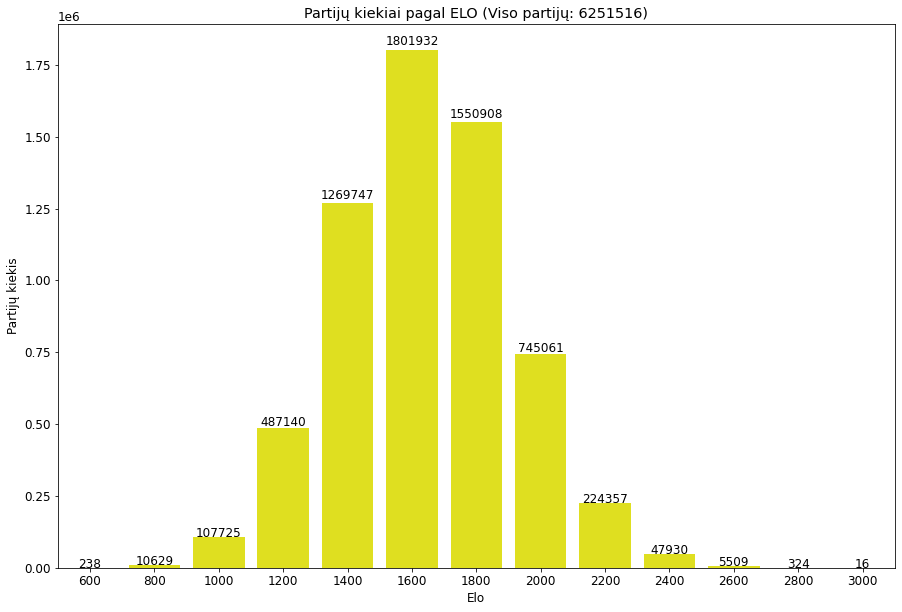

In [15]:
games_count = df['Opening'].count()
matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x='WhiteElo', y='Games count', data=elo_groups_games_count, color='yellow')
ax.set(xlabel='Elo', ylabel='Partijų kiekis', title=f'Partijų kiekiai pagal ELO (Viso partijų: {games_count})')
show_values(ax)

Atsižvelgiant į nurodytą histogramą, matosi, jog  duomenys yra pasiskirstę tarp 600 ir 3000 ELO, bei didžioji dalis žaidimų vyko tarp žaidėjų, esančių tarp 1400 ir 1800 ELO rango.

## Hipotezė - žaidėjai, turintys bent šimtu didesnį rangą, negu savo oponentas, laimės 80% žaistų partijų
Šiai hipotezei patikrinti buvo atrinktos visos partijos, kuriose tarp žaidėjų buvo 100 ELO skirtumas. Partijos buvo sugrupuotos į kas 100 ELO skirtumo prieaugio grupes ir buvo apskaičiuoti šių grupių laimėjimo procentai. Visi duomenys atvaizduoti grafike. 

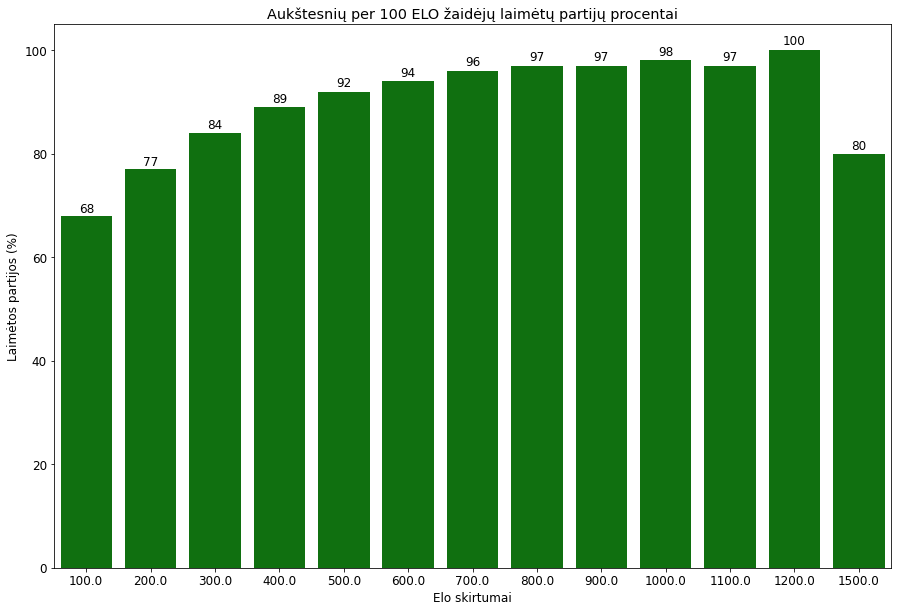

In [16]:
lower_elo_winners = df[(df['Winner'] != 'Draw') & (df['Winner'] != df['HigherEloColor']) & (df['EloDifference'] > 100)].sort_values(by=['EloDifference'], ascending=False)
lw_df_games = df[df['EloDifference'] > 100]
lw_df_games = pd.DataFrame((lw_df_games.groupby(((lw_df_games['EloDifference']//100)*100))['Result'].count()).reset_index(name="Total games"))
lw_df = pd.DataFrame(((lower_elo_winners.groupby((lower_elo_winners['EloDifference']//100)*100))['Result'].count()).reset_index(name="Lower win"))
lower_elo_df = pd.merge(lw_df_games, lw_df, on='EloDifference')
lower_elo_df['HigherWinPercentage'] = (100 - (lower_elo_df['Lower win'] / lower_elo_df['Total games']) * 100).round()
chart = sns.barplot(x='EloDifference', y='HigherWinPercentage', data=lower_elo_df, color='green')
plt.title("Aukštesnių per 100 ELO žaidėjų laimėtų partijų procentai")
plt.ylabel('Laimėtos partijos (%)')
plt.xlabel('Elo skirtumai')
show_values(chart)

Sprendžiant iš grafiko hipotezė nepasitvirtino, nes 80% laimėjimas buvo pasiektas tik esant 300 ELO skirtumui. Toliau einant per grafiką taip pat galima įžvelgti, jog kylant iki 1000 ELO skirtumo aukštesnio rango žaidėjo laimėjimo procentai kyla, tačiau ties 1100 yra nukritimas per 1%, o tarp 1200 ir 1500 yra net 20% kritimas

## Hipotezė - žemesnio ranko žaidėjai dažniausiai laimi prieš oponentus gaunant matą
Priklausomai nuo šachmatų žaidimo tipo, pergalė yra pasiekiama nebūtinai Matu. Žaidėjai gali laimėti, jeigu:
1. Priešininkas pasiduoda/išeina iš žaidimo (Abandon)
2. Gaunant matą
3. Priešininkas pažeidžia taisykles (Rules infraction)
4. Pasibaigia ėjimo laikas (Žaidžiant Blitz formatą)
Norint patikrinti išsikeltą hipotezę buvo atfiltruoti ir suskaičiuoti visi žaidimai, kur tarp žaidėjų buvo bent 100 ELO skirtumas ir kuriuos laimėjo žemesnio rango žaidėjas. Gauti duomenys atvaizduoti stulpeline diagrama

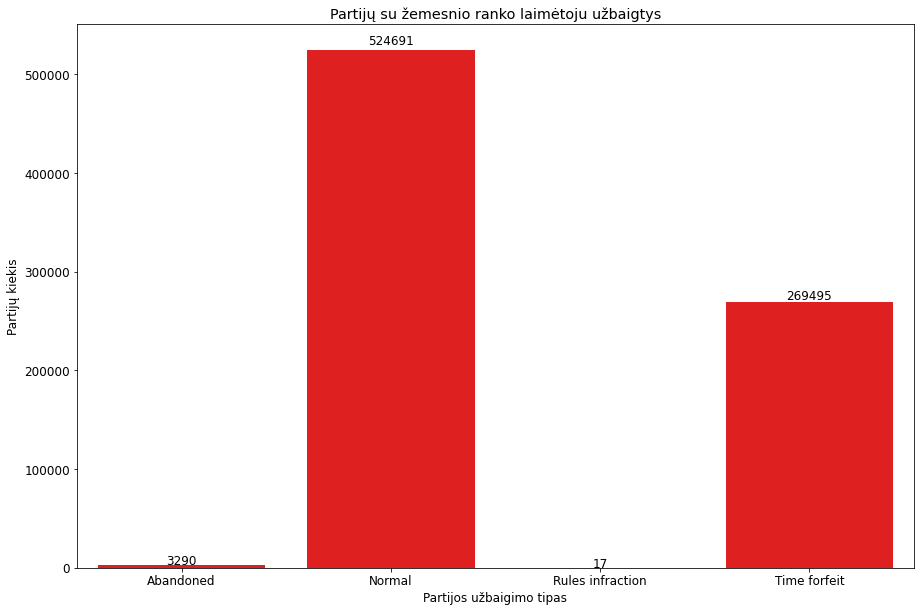

In [17]:
lower_elo_win_types = pd.DataFrame(lower_elo_winners.groupby('Termination')['Result'].count()).reset_index()
lower_elo_win_types['Result']
p = sns.barplot(x='Termination', y='Result', data=lower_elo_win_types, color='red', ci=None)
plt.xlabel('Partijos užbaigimo tipas')
plt.ylabel('Partijų kiekis')
plt.title('Partijų su žemesnio ranko laimėtoju užbaigtys')
show_values(p)

Iš sudarytos diagramos galima daryti išvadą, jog didesnė dalis žaidimų buvo laimėta gaunant matą, hipotezė patvirtinta.

## Kokie yra patys populiariausi debiutai?
Debiutas (angl. "Opening") yra pradinė partijos būsenas. Dauguma debiutų turi savo pavadinimus. Debiutų populiarumas buvo tikrinimas agreguojant jų pavadinimus pagal Elo grupes ir atvaizduojant gautus duomenis lentelėje.

In [18]:
df4 = (df.groupby([((df['WhiteElo']//200)*200), 'Opening'])['Opening'].count()).reset_index(name="Count")
df4 = (df4.groupby(['WhiteElo', 'Opening'])['Count'].max()).reset_index()
df5 = pd.DataFrame(df4.groupby(['WhiteElo'], sort=False)['Count'].max())
white_openings = pd.merge(df5, df4, on=['WhiteElo', 'Count'], how='inner')
white_openings = white_openings[white_openings['Count'] > 1]
df4 = (df.groupby([((df['BlackElo']//200)*200), 'Opening'])['Opening'].count()).reset_index(name="Count")
df4 = (df4.groupby(['BlackElo', 'Opening'])['Count'].max()).reset_index()
df5 = pd.DataFrame(df4.groupby(['BlackElo'], sort=False)['Count'].max())
black_openings = pd.merge(df5, df4, on=['BlackElo', 'Count'], how='inner')
black_openings = black_openings[black_openings['Count'] > 1].reset_index()
all_openings = pd.merge(white_openings, black_openings, left_on='WhiteElo', right_on='BlackElo', how='left').reset_index()
columns_to_drop = ['level_0','index','BlackElo']
all_openings.drop(columns_to_drop, axis=1, inplace=True)
all_openings.rename({'WhiteElo': 'Elo', 'Count_x': 'White count', 'Opening_x':'White opening', 'Count_y':'Black count', 'Opening_y':'Black opening'}, inplace=True, axis='columns')
display(HTML(all_openings.to_html()))

,Elo,White count,White opening,Black count,Black opening
0,600,13,Van't Kruijs Opening,17,Scandinavian Defense
1,800,438,Van't Kruijs Opening,387,Van't Kruijs Opening
2,1000,5015,Van't Kruijs Opening,3756,Van't Kruijs Opening
3,1200,16698,Van't Kruijs Opening,14035,Van't Kruijs Opening
4,1400,38963,Van't Kruijs Opening,31314,Van't Kruijs Opening
5,1600,37997,Van't Kruijs Opening,40070,Van't Kruijs Opening
6,1800,28042,Modern Defense,28346,Modern Defense
7,2000,12253,Modern Defense,13752,Modern Defense
8,2200,3826,Modern Defense,3977,Modern Defense
9,2400,843,Hungarian Opening,859,Old Benoni Defense


Iš gautų duomenų matosi, jog baltų figurėlių žaidėjai tarp 600 ir 1600 elo dažniausiai naudojo "Van't Krujis Opening" debiutą, tas pats tiesa ir apie juodųjų figurėlių žaidėjus, išskyrus 600 elo rango žaidėjus, tarp kurių populiariausias debiutas buvo "Scandinavian Defense". Top 3 debiutai pagal populiarumą:
1. Van't Kruijs Opening
2. Modern Defense
3. Old Benoni Defense

## Koks yra pats populiariausias šachmatų žaidimo tipas?
Šahmatai turi daugiau negu vieną būdą žaisti. Esminis skirtumas tarp visų variacijų yra skirtas laikas partijai. Šiam klausimui atsakyt buvo sugrupuotos partijos pagal jų tipą ir apskaičiuoti kiek procentų iš visų žaistų partijų yra kiekvieno tipo. Gauti duomenys atvaizduoti stulpeline diagrama.

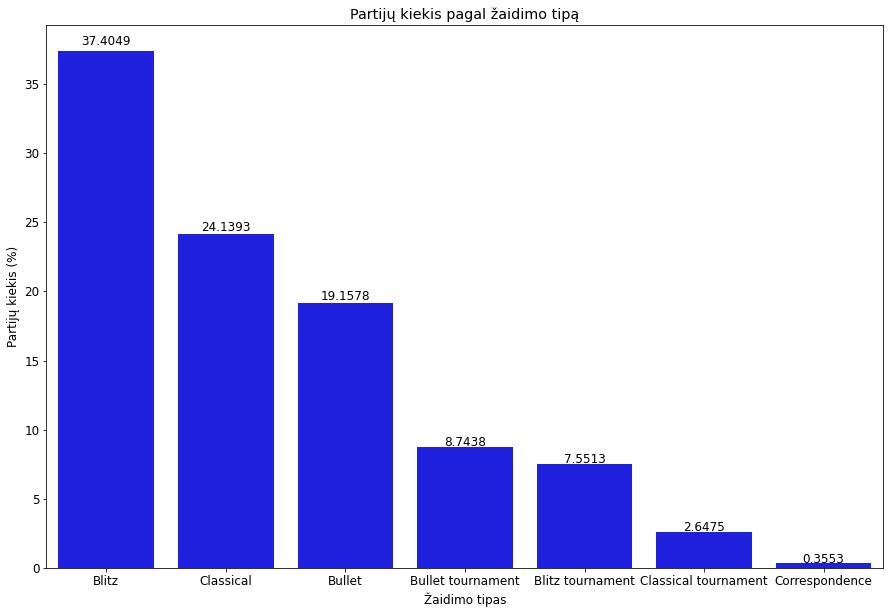

In [19]:
game_modes = df.groupby('Event')['Event'].count().reset_index(name='Event count').sort_values(by=['Event count'], ascending=False)
game_modes['Game percentage'] = (game_modes['Event count'] / games_count) * 100
ax = sns.barplot(x='Event', y='Game percentage', data=game_modes, color='blue')
plt.title('Partijų kiekis pagal žaidimo tipą')
plt.xlabel('Žaidimo tipas')
plt.ylabel('Partijų kiekis (%)')
show_values(ax, whole_number=False)

Atsižvelgiant į grafiką, galima daryti išvadą, jog pats populiariausias būdas žaisti šahmatus yra "Blitz". Šis tipas yra labai mėgiamas žaidėjų ir žiūrovų dėl to, kad partijos yra greitos ir trumpos.

## Hipotezė - dauguma partijų baigiasi kai pasiekiamas matas
Kaip buvo minėta aukščiau šachmatų partija gali baigtis vienu iš keturių būdų. Norint patikrinti šią hipotezę buvo sugrupuoti visos partijos pagal jų užbaigties tipus ir suskaičiuojama kiek procentų partijų baigėsi atitinkamu būdu. Gauti duomenys atvaizduojami stulpeline diagrama.

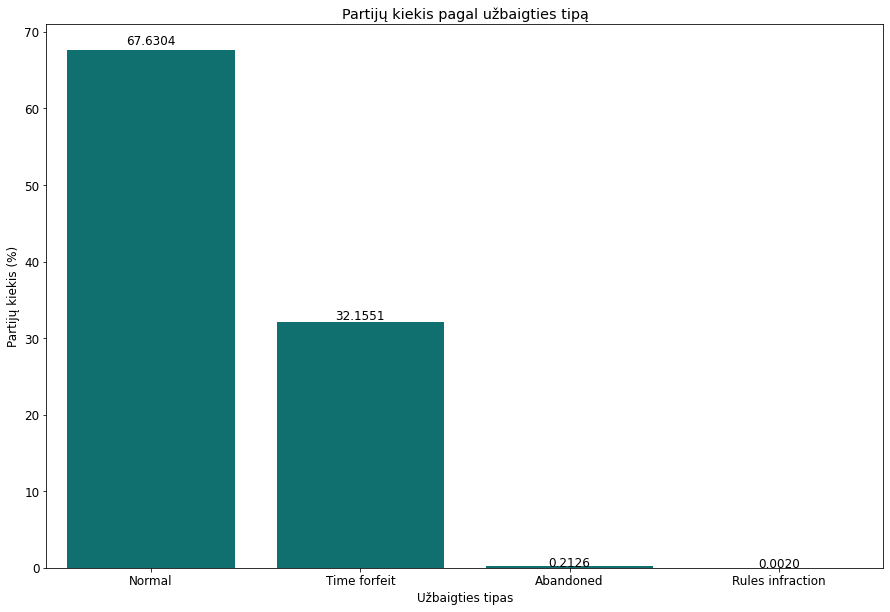

In [20]:
terminations = df.groupby('Termination')['Termination'].count().reset_index(name='Termination count').sort_values(by=['Termination count'], ascending=False)
terminations['Game percentage'] = (terminations['Termination count'] / games_count) * 100
ax = sns.barplot(x='Termination', y='Game percentage', data=terminations, color='teal')
plt.title('Partijų kiekis pagal užbaigties tipą')
plt.xlabel('Užbaigties tipas')
plt.ylabel('Partijų kiekis (%)')
show_values(ax, whole_number = False)

Iš grafiko matosi, jog populiariausia žaidimo užbaigtis yra pasiekiant matą.

## Hipotezė - baltų figurėlių žaidėjai laimi dažniau negu juodi
Šahmatuose baltosios figūrėlės visada turi pirmą ėjimą ir galima teigti turi pranašumą. Norint patikrint šią hipotezę buvo suskaičiuoti visos juodųjų ir baltųjų figurėlių pergalės ir kiek procentų partijų laimėjo juodos/baltos. Šie duomenys buvo grupuojami pagal elo grupes, norint ištirti baltų/juodų figurėlių laimėjimų procentus, keičiantis rangams. Gauti duomenys atvaizduoti linijine diagrama.

In [21]:
elo_groups_games_count = (df.groupby((df['WhiteElo']//200)*200)['WhiteElo'].count()).reset_index(name='Games count')
black_winners = df[df['Winner'] == 'Black']
black_wins_by_elo_group = black_winners.groupby((black_winners['WhiteElo']//200)*200)['WhiteElo'].count().reset_index(name='Black wins')
white_winners = df[df['Winner'] == 'White']
white_wins_by_elo_group = white_winners.groupby((white_winners['WhiteElo']//200)*200)['WhiteElo'].count().reset_index(name='White wins')
all_wins_by_elo_group = pd.merge(white_wins_by_elo_group, black_wins_by_elo_group, left_on='WhiteElo', right_on='WhiteElo', how='inner')
elo_groups_games_count = pd.merge(elo_groups_games_count, all_wins_by_elo_group, on='WhiteElo', how='inner')
elo_groups_games_count['White win%'] = (elo_groups_games_count['White wins'] / elo_groups_games_count['Games count']) * 100
elo_groups_games_count['Black win%'] = (elo_groups_games_count['Black wins'] / elo_groups_games_count['Games count']) * 100

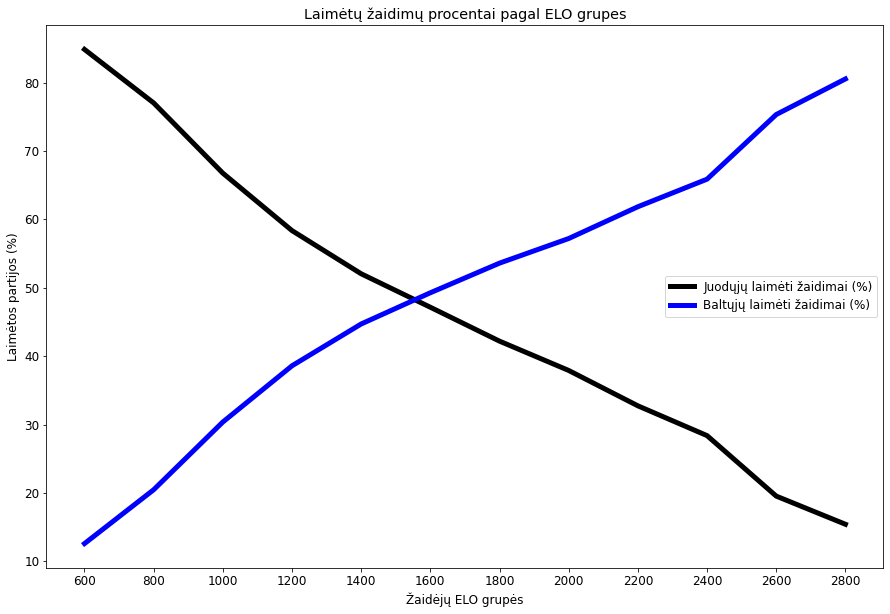

In [22]:
elo_groups = elo_groups_games_count['WhiteElo'].values
black_win_percent = elo_groups_games_count['Black win%'].values
white_win_percent = elo_groups_games_count['White win%'].values

plt.plot(elo_groups, black_win_percent, label = "Juodųjų laimėti žaidimai (%)", lw=5, color='black')
plt.plot(elo_groups, white_win_percent, label = "Baltųjų laimėti žaidimai (%)", lw=5, color='blue')
plt.legend(loc=5)
plt.title('Laimėtų žaidimų procentai pagal ELO grupes')
plt.ylabel('Laimėtos partijos (%)')
plt.xlabel('Žaidėjų ELO grupės')
plt.xticks(elo_groups)
plt.show()


Iš grafiko matosi, jog hipotezė yra teisinga, tik nuo maždaug 1550 elo, nes tik tada baltųjų figurėlių žaidėjai laimi daugiau žaidimų negu juodųjų. Taip yra dėl to, jog aukštesnio rango žaidėjai geriau moka išnaudoti gautą pirmo ėjimo pranašumą.